In [1]:
import math
from glob import glob
import seaborn as sns
from torchsummary import summary
from torch_snippets import *
from torch_snippets.torch_loader import Report
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import io
from sklearn.metrics import cohen_kappa_score
import torch.nn.functional as F
import cv2
import umap
import gc
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
from torch import nn
#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [2]:
orig_dir   = './larvae'
nclasses   = 2

width       = 224
height      = 224
nchannels   = 3
maxval      = 255.
input_shape = (nchannels,height,width)

data = glob(orig_dir+"/*.png")

# Extract labels from filenames (0 for class 1, 1 for class 2)
# This is crucial for the 'stratify' parameter
labels = [int(f.split('/')[-1].split('_')[0]) - 1 for f in data]

# The 'stratify=labels' argument ensures both sets have the same class proportion
train_val_files, testset, train_val_labels, _ = train_test_split(
    data, labels, test_size=0.30, random_state=42, stratify=labels)

# now we split the temporary 70% set into the final training and validation sets.
# The validation set is 0.20 of the original total, which is 0.20/0.70 of this temporary set.
val_size_relative = 0.20 / (0.50 + 0.20)
trainset, validset, _, _ = train_test_split(
    train_val_files, train_val_labels, test_size=val_size_relative, random_state=42, stratify=train_val_labels)


# verifying
print(f"Total: {len(data)}")
print(f"Training: {len(trainset)}")
print(f"Validation: {len(validset)}")
print(f"Test: {len(testset)}")

# Set output model name
model_name  = 'LarvaeCNN.pth'

Total: 1598
Training: 798
Validation: 320
Test: 480


### Create image datasets with some preprocessing: output a list of image tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized,
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters.

prep = transforms.Compose([
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation,
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 3
# of epochs, we are actually implementing data augmentation.

aug = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR,
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((height,width), interpolation=transforms.InterpolationMode.BILINEAR,
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, ix): # returns the item at position ix
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()
        return(image,target)

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

### Visualize selected images

Number of images: 798
Images are 224x224x3
Class of the image:  2


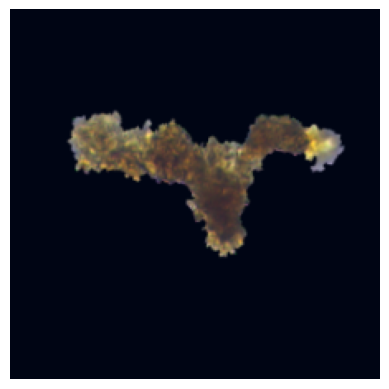

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[50] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
plt.axis('off')
print("Class of the image: ", target+1)
plt.show()

}### Generate batches with batchsize images at random

In [6]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

next(iter(trainload)) # inspect next item in the trainload

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
           [-

### ConvNet model

In [7]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(5, 5),
                  stride=1, padding=2, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class LarvaNet(nn.Module):

    def __init__(self, input_shape, num_classes, channels=[32, 256]):
        super(LarvaNet, self).__init__()


        self.features = nn.Sequential(
            conv_block(input_shape[0], channels[0], 2),
            conv_block(channels[0], channels[1], 2)
        )

        final_channels = channels[-1]
        self.classifier = nn.Sequential(
            nn.Linear(in_features=(input_shape[1]//4)*(input_shape[2]//4)*final_channels, out_features=64, bias=True),
            nn.Dropout(0.20),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

        self._initialize_weights()
        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)

        return y

    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0
                    m.bias.data.zero_()

### Create the model

In [8]:
# del trainset, validset, testset
# gc.collect()
# torch.cuda.empty_cache()

In [8]:
original_channels = [32, 256]
model = LarvaNet(input_shape, nclasses, channels=original_channels).to(device)
summary(model,input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,400
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5        [-1, 256, 112, 112]         204,800
       BatchNorm2d-6        [-1, 256, 112, 112]             512
              ReLU-7        [-1, 256, 112, 112]               0
         MaxPool2d-8          [-1, 256, 56, 56]               0
            Linear-9                   [-1, 64]      51,380,288
          Dropout-10                   [-1, 64]               0
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
Total params: 51,588,194
Trainable params: 51,588,194
Non-trainable params: 0
-------------------------

### Define the loss function with L2 regularization

In [9]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long())
    # add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [10]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.9 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
# gamma=0.9 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.9)

### Define training and validation functions

In [11]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [12]:
n_epochs = 100
log = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):

    # training loop
    running_trn_loss = 0.0
    running_trn_acc = 0.0
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        running_trn_loss += loss
        running_trn_acc += acc
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    # calculate train loss e acc mean
    epoch_trn_loss = running_trn_loss / N
    epoch_trn_acc = running_trn_acc / N

    # validation loop
    model.eval() # Set model to evaluation mode once before the loop
    running_val_loss = 0.0
    running_val_acc = 0.0
    N_val = len(validload)
    val_preds_list = []
    val_targets_list = []

    with torch.no_grad():
        for bx, data in enumerate(validload):
            ims, targets = data
            ims, targets = ims.to(device), targets.to(device)

            preds = model(ims)

            loss, acc = criterion(model, preds, targets)

            running_val_loss += loss.item()
            running_val_acc += acc.item()
            log.record((ex+(bx+1)/N_val), val_loss=loss.item(), val_acc=acc.item(), end='\r')

            pred_labels = torch.max(preds, 1)[1]
            val_preds_list.extend(pred_labels.cpu().numpy())
            val_targets_list.extend(targets.cpu().numpy())

    #  calculate validation loss e acc mean
    epoch_val_loss = running_val_loss / N_val
    epoch_val_acc = running_val_acc / N_val

    # calculate kappa cohen
    kappa = cohen_kappa_score(val_targets_list, val_preds_list)
    log.record(ex+1, val_kappa=kappa, end='\r') # Ainda gravamos no log para o gráfico

    # print after 10 epochs
    if (ex+1)%10==0:
        print(f"EPOCH: {ex+1}  ",
              f"Trn_Loss: {epoch_trn_loss:.4f}  ",
              f"Trn_Acc: {epoch_trn_acc:.4f}  ",
              f"Val_Loss: {epoch_val_loss:.4f}  ",
              f"Val_Acc: {epoch_val_acc:.4f}  ",
              f"Val_Kappa: {kappa:.4f}")

    lr_scheduler.step()

EPOCH: 10.000  val_kappa: 0.128  (84.15s - 757.38s remaining)EPOCH: 10   Trn_Loss: 0.3074   Trn_Acc: 0.8887   Val_Loss: 0.3579   Val_Acc: 0.8562   Val_Kappa: 0.1280
EPOCH: 20.000  val_kappa: 0.297  (168.74s - 674.94s remaining)EPOCH: 20   Trn_Loss: 0.2667   Trn_Acc: 0.8973   Val_Loss: 0.3199   Val_Acc: 0.8750   Val_Kappa: 0.2967
EPOCH: 30.000  val_kappa: 0.270  (253.44s - 591.36s remaining)EPOCH: 30   Trn_Loss: 0.2485   Trn_Acc: 0.9036   Val_Loss: 0.3248   Val_Acc: 0.8719   Val_Kappa: 0.2703
EPOCH: 40.000  val_kappa: 0.297  (338.38s - 507.57s remaining)EPOCH: 40   Trn_Loss: 0.2451   Trn_Acc: 0.9174   Val_Loss: 0.2901   Val_Acc: 0.8750   Val_Kappa: 0.2967
EPOCH: 50.000  val_kappa: 0.443  (423.22s - 423.22s remaining)EPOCH: 50   Trn_Loss: 0.2321   Trn_Acc: 0.9158   Val_Loss: 0.2683   Val_Acc: 0.8938   Val_Kappa: 0.4426
EPOCH: 60.000  val_kappa: 0.635  (508.33s - 338.89s remaining)EPOCH: 60   Trn_Loss: 0.2155   Trn_Acc: 0.9174   Val_Loss: 0.2380   Val_Acc: 0.9219   Val_Kappa: 0.6354
EPOCH

### Plot the results

100%|██████████| 201/201 [00:00<00:00, 6417.07it/s]


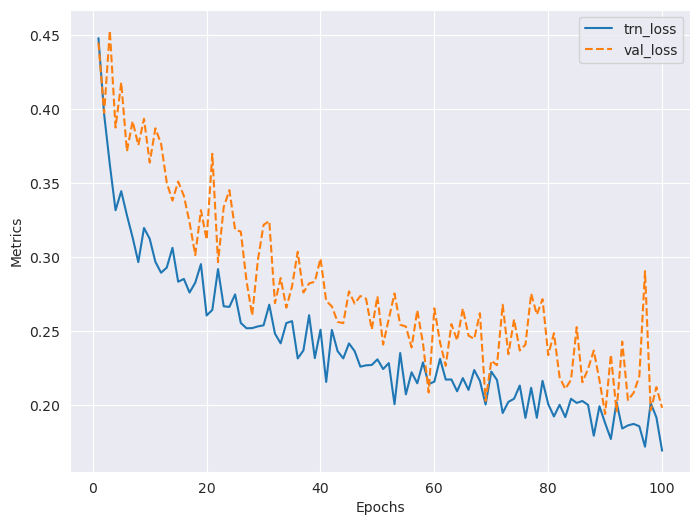

100%|██████████| 201/201 [00:00<00:00, 6433.37it/s]


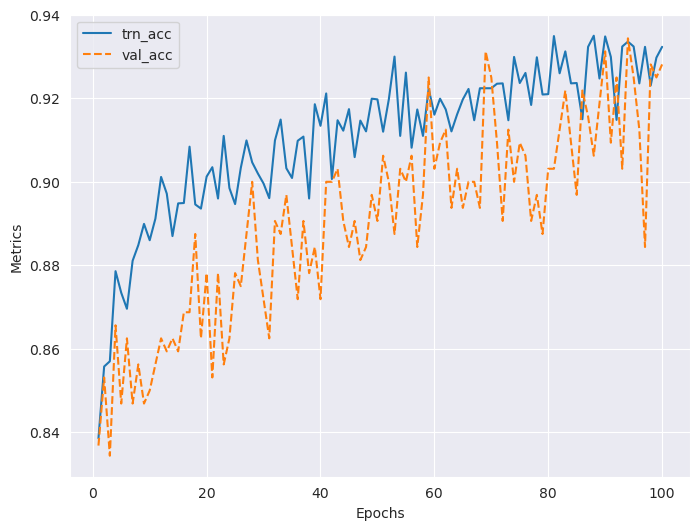

In [13]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [14]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0

    all_predictions = []
    all_targets = []

    # Set the model to evaluation mode
    model.eval()
    # Disabling gradient
    with torch.no_grad():
        for bx, data in enumerate(testload):
            # This part calculates the loss and accuracy per batch, which we will average
            loss, acc  = validate_batch(model, data, criterion, device)
            mean_loss += loss
            mean_acc  += acc

            ims, targets = data
            ims, targets = ims.to(device), targets.to(device)

            preds = model(ims)
            pred_labels = torch.max(preds, 1)[1]

            all_predictions.extend(pred_labels.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate the final average metrics
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    kappa = cohen_kappa_score(all_targets, all_predictions)

    # Return all three metrics
    return(mean_loss, mean_acc, kappa)


# The function now returns three values
(loss, acc, kappa) = Test(model, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.220924  Acc: 0.918750  Kappa: 0.613766


### Save the model

In [15]:
# torch.save(model.to('cpu').state_dict(), model_name)

### Visualize activations at the output of the last convolutional block for a given image

In [ ]:
# model.load_state_dict(torch.load('LarvaeCNN.pth', map_location='cuda'))
# model.to('cuda')

CorelNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=802816, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [16]:
def get_larvanet_feature_map(model, input_tensor: torch.Tensor) -> torch.Tensor:
    """
    Simple method: Extract feature map by calling model.features directly

    Args:
        model: LarvaNet model instance
        input_tensor: Input tensor
    image, target = trainset[100] # it executes getitem
    image     = image.permute(1,2,0).numpy()
    image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
    image     = image.astype('uint8')
    print("Images are {}x{}x{}".format(width,height,nchannels))
    plt.imshow(image)
        Returns:
        Feature map from the feature extractor (before flattening)
    """
    model.eval()
    with torch.no_grad():
        feature_map = model.features(input_tensor)
    return feature_map

In [17]:
def visualize_larvae_features(feature_map: torch.Tensor,
                               max_channels: int = 16,
                               start_channel: int = 0,
                               figsize: tuple = (15, 10),
                               sample_idx: int = 0):
    """
    Visualize LarvaNet feature maps

    Args:
        feature_map: Feature map tensor (batch_size, channels, height, width)
        max_channels: Maximum number of channels to display
        start_channel: Starting channel index (0-based)
        figsize: Figure size for matplotlib
        sample_idx: Which sample from the batch to visualize
    """
    if feature_map.dim() == 4:
        feature_map_sample = feature_map[sample_idx]  # Shape: (channels, height, width)
    else:
        feature_map_sample = feature_map

    total_channels = feature_map_sample.shape[0]
    end_channel = min(start_channel + max_channels, total_channels)
    num_channels = end_channel - start_channel

    if start_channel >= total_channels:
        raise ValueError(f"start_channel ({start_channel}) must be less than total channels ({total_channels})")

    print(f"Feature map shape: {feature_map.shape}")
    print(f"Total channels: {total_channels}")
    print(f"Visualizing channels {start_channel}-{end_channel-1} from sample {sample_idx}")

    # new addition: a list to get dead filters
    dead_filter_indexs = []

    # Calculate grid dimensions
    cols = 4
    rows = (num_channels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    if rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    for i in range(num_channels):
        ax = axes[i]
        channel_idx = start_channel + i
        channel_data = feature_map_sample[channel_idx].cpu().numpy()
        if channel_data.max() == 0:
            dead_filter_indexs.append(channel_idx)
        im = ax.imshow(channel_data, cmap='viridis')
        ax.set_title(f'Channel {channel_idx}\nMin: {channel_data.min():.2f}\nMax: {channel_data.max():.2f}',
                    fontsize=10)
        ax.axis('off')
        plt.colorbar(im, ax=ax, shrink=0.6)

    # Hide unused subplots
    for i in range(num_channels, len(axes)):
        axes[i].axis('off')

    plt.suptitle(f'LarvaNet Feature Maps - Channels {start_channel}-{end_channel-1}\nShape: {feature_map.shape}',
                 fontsize=14)
    plt.tight_layout()
    plt.show()
    print("Analysis for this sample:")
    if dead_filter_indexs:
        print(f"Found {len(dead_filter_indexs)} dead filters in the visualized range.")
        print(f"Indices: {dead_filter_indexs}")
    else:
        print("No dead filters found in the visualized range.")

In [18]:
model.to(device)

LarvaNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=802816, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [30]:
target_image, target = trainset[14]
target_image = target_image.unsqueeze(0).to(device)

Feature map shape: torch.Size([1, 256, 56, 56])
Total channels: 256
Visualizing channels 0-15 from sample 0


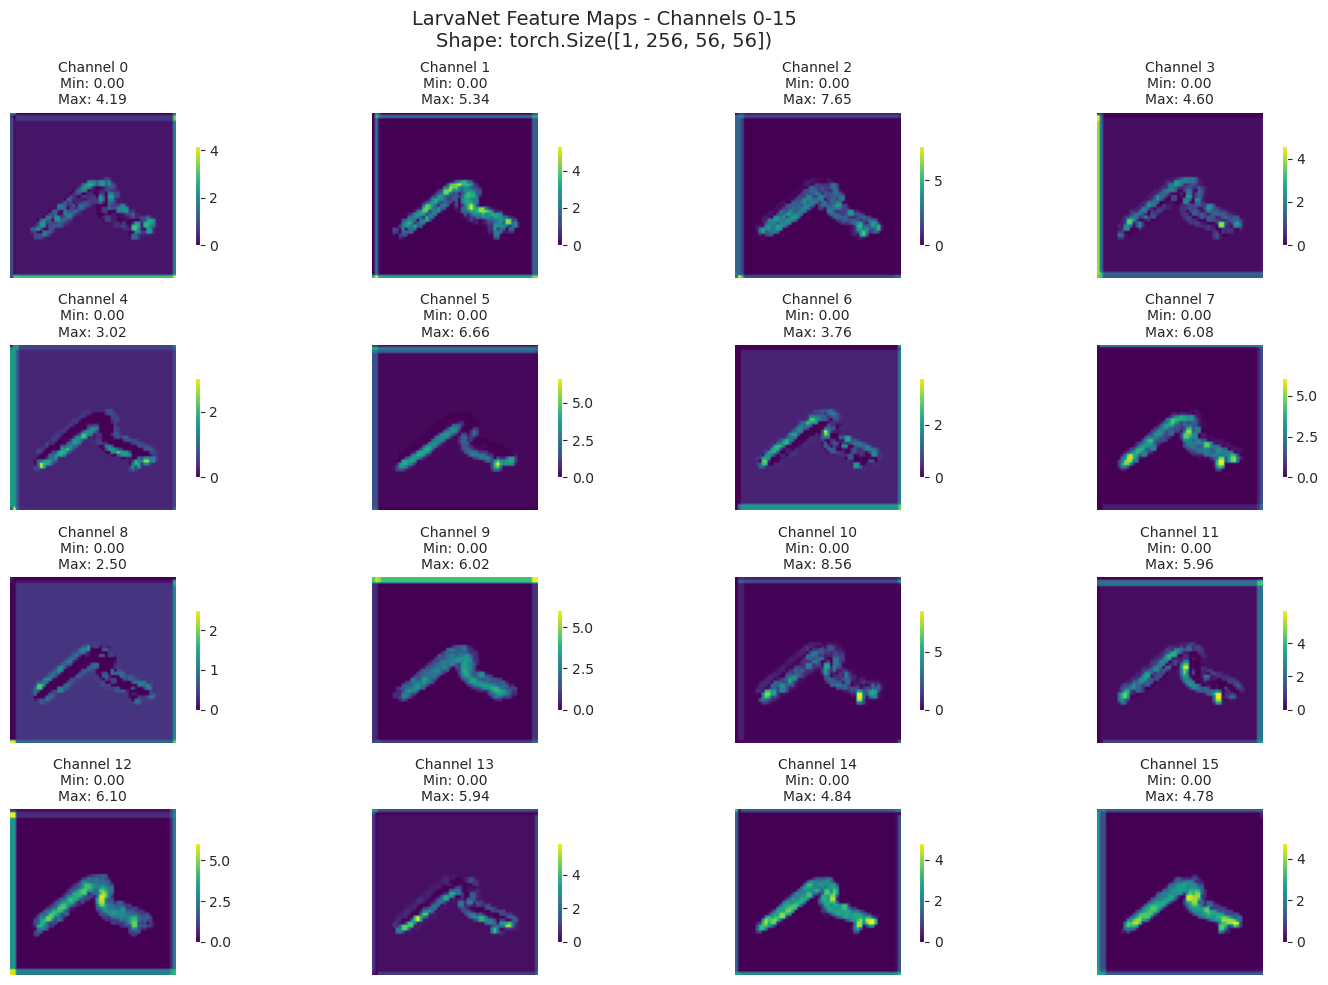

Analysis for this sample:
No dead filters found in the visualized range.


In [31]:
featmap = get_larvanet_feature_map(model,target_image)
visualize_larvae_features(featmap, max_channels=16, start_channel=0)

dead filters are probably non-existant, but some filters are activating mostly in the exterior part of the object (filter 41) and others inside the whole object (12).

In [21]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.model.eval()
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)

        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1).squeeze()

        # backward pass
        self.model.zero_grad()
        class_score = model_output[:, class_idx]
        class_score.backward(retain_graph=True)
        # get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # Calculate weights
        weights = torch.mean(gradients, dim=[2, 3])

        # Generate CAM
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32).to(input_image.device)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i, :, :]

        # Apply ReLU and normalize
        cam = F.relu(cam)
        if torch.max(cam) > 0:
            cam = cam - torch.min(cam)
            cam = cam / torch.max(cam)

        return cam.detach().cpu().numpy(), model_output.detach()

def visualize_gradcam(orig_image, cam, alpha=0.4):
    # Resize CAM to match original image size
    cam_resized = cv2.resize(cam, (orig_image.shape[1], orig_image.shape[0]))

    # Create heatmap and overlay it
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlayed = cv2.addWeighted(orig_image, 1 - alpha, heatmap, alpha, 0)

    return overlayed, heatmap

def denormalize(tensor):
    # These are the means and stds used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # we need to rearrange the tensor dimensions
    tensor = tensor.clone().permute(1, 2, 0)
    tensor = tensor * torch.tensor(std, device=tensor.device) + torch.tensor(mean, device=tensor.device)

    # clip values to be between 0 and 1 and convert to a NumPy array for plotting
    tensor = torch.clamp(tensor, 0, 1)
    return (tensor.cpu().numpy() * 255).astype(np.uint8)



In [27]:
print("Finding examples in the test set...")
# Indices for: True Positive, False Negative, True Negative, False Positive
tp_idx, fn_idx, tn_idx, fp_idx = -1, -1, -1, -1

model.eval()
with torch.no_grad():
    for i, (img_tensor, label) in enumerate(trainset):
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)
        output = model(img_tensor_batch)
        prediction = torch.argmax(output, dim=1).item()

        # Case: True label is Larva (0)
        if label == 0:
            if prediction == 0 and tp_idx == -1:
                tp_idx = i
            elif prediction == 1 and fn_idx == -1:
                fn_idx = i

        # Case: True label is Impurity (1)
        elif label == 1:
            if prediction == 1 and tn_idx == -1:
                tn_idx = i
            elif prediction == 0 and fp_idx == -1:
                fp_idx = i

        # Stop when all four examples are found
        if all(idx != -1 for idx in [tp_idx, fn_idx, tn_idx, fp_idx]):
            break

print(f"True Positive (Larva as Larva) found at index: {tp_idx}")
print(f"False Negative (Larva as Impurity) found at index: {fn_idx}")
print(f"True Negative (Impurity as Impurity) found at index: {tn_idx}")
print(f"False Positive (Impurity as Larva) found at index: {fp_idx}")

Finding examples in the test set...
True Positive (Larva as Larva) found at index: 14
False Negative (Larva as Impurity) found at index: 4
True Negative (Impurity as Impurity) found at index: 0
False Positive (Impurity as Larva) found at index: 94


Plot the grad-cam of a correct and a incorrect prediction of the 2 classes

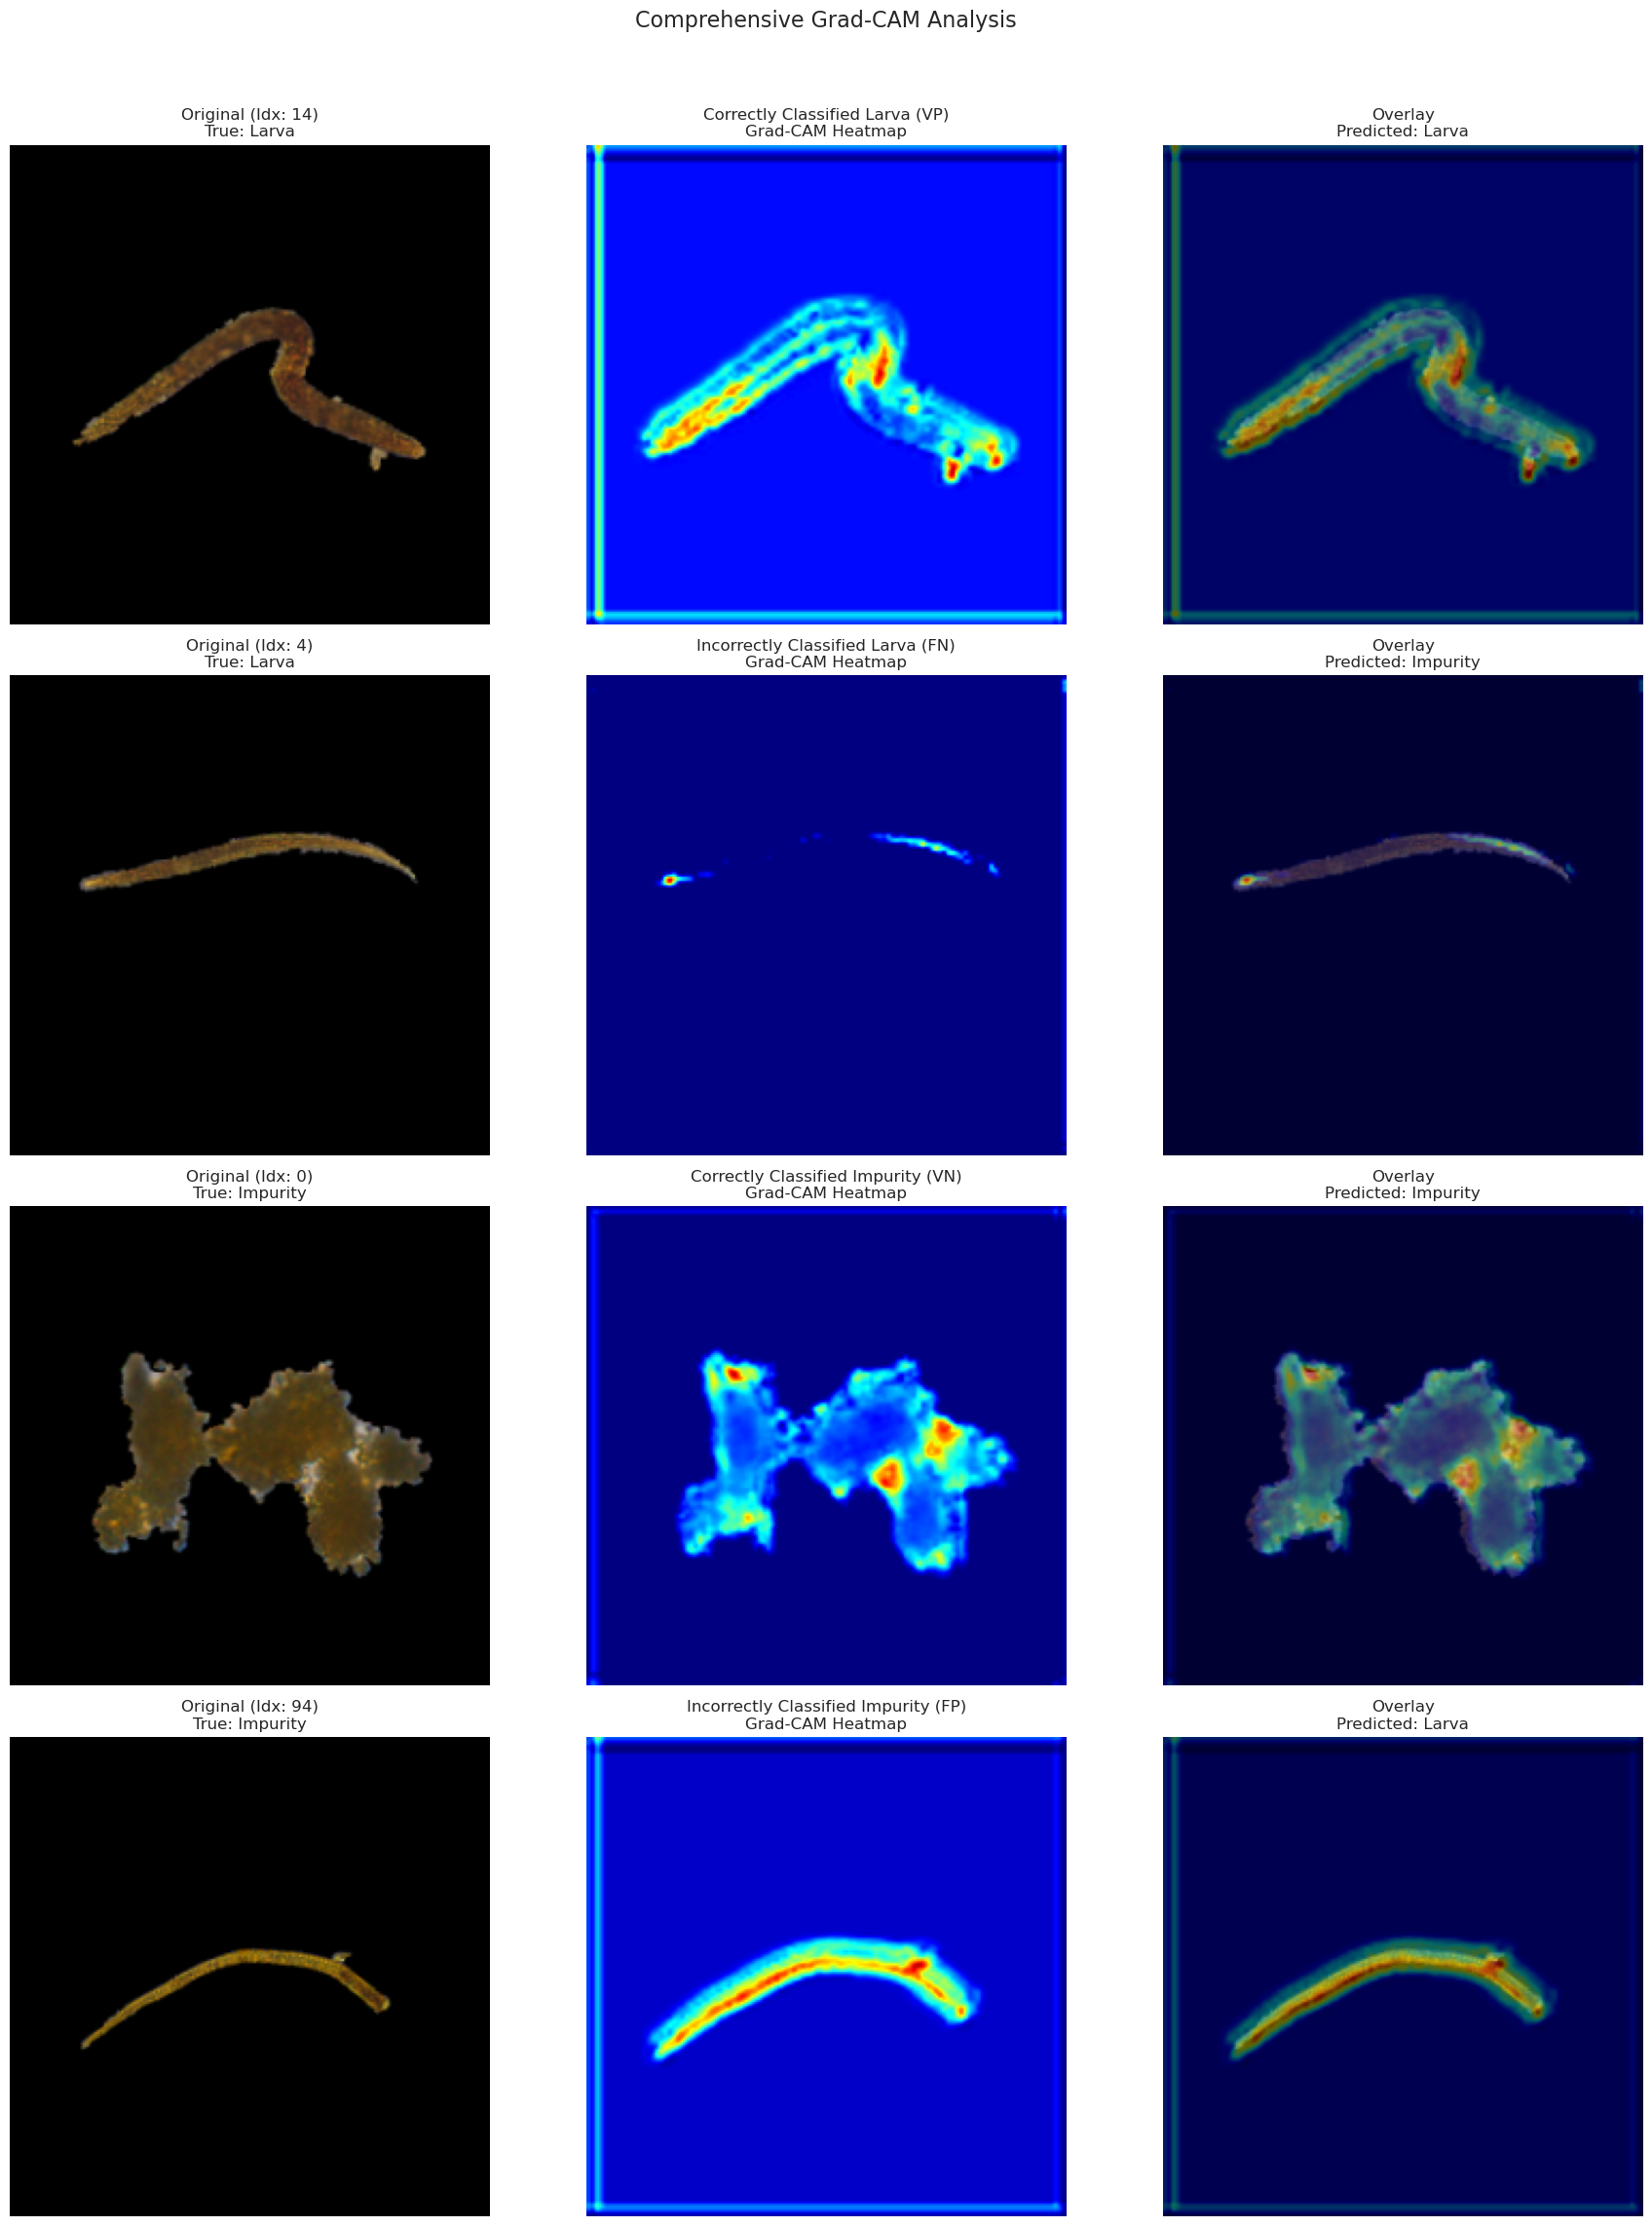

In [28]:
target_layer = model.features[1][0]
grad_cam = GradCAM(model, target_layer)
class_names = {0: 'Larva', 1: 'Impurity'}

# Create a 4x3 grid for the plots
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
fig.suptitle('Comprehensive Grad-CAM Analysis', fontsize=16)

# Helper function to avoid code repetition
def plot_case(ax_row, case_idx, case_title):
    if case_idx == -1:
        print(f"Could not find an example for: {case_title}")
        ax_row[0].set_title(f"Example not found for\n{case_title}")
        for ax in ax_row: ax.axis('off')
        return

    img_tensor, label = trainset[case_idx]
    orig_image_np = denormalize(img_tensor)

    cam, output = grad_cam(img_tensor.unsqueeze(0).to(device))
    pred_label = torch.argmax(output, dim=1).item()
    overlay, heatmap = visualize_gradcam(orig_image_np, cam)

    ax_row[0].imshow(orig_image_np)
    ax_row[0].set_title(f'Original (Idx: {case_idx})\nTrue: {class_names[label]}')
    ax_row[1].imshow(heatmap)
    ax_row[1].set_title('Grad-CAM Heatmap')
    ax_row[2].imshow(overlay)
    ax_row[2].set_title(f'Overlay\nPredicted: {class_names[pred_label]}')

# Plot all 4 cases
plot_case(axes[0], tp_idx, "True Positive")
plot_case(axes[1], fn_idx, "False Negative")
plot_case(axes[2], tn_idx, "True Negative")
plot_case(axes[3], fp_idx, "False Positive")

# Add overall titles for rows
axes[0, 1].set_title("Correctly Classified Larva (VP)\n" + axes[0, 1].get_title(), fontsize=12)
axes[1, 1].set_title("Incorrectly Classified Larva (FN)\n" + axes[1, 1].get_title(), fontsize=12)
axes[2, 1].set_title("Correctly Classified Impurity (VN)\n" + axes[2, 1].get_title(), fontsize=12)
axes[3, 1].set_title("Incorrectly Classified Impurity (FP)\n" + axes[3, 1].get_title(), fontsize=12)


for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

The model is focusing in the objects of interest to make the decisions, even the wrong ones. In the false negative case, the general focus of the model in the object was smaller compared to the TP case.

# Activation Maps


here, we wanna see the results (activation maps) of each one of the 256 filters as output images.

In [34]:
output_dir = './activation_maps_class_2'
os.makedirs(output_dir, exist_ok=True)
index_a = 4
index_b = 0
# Get the image tensor and prepare it for the model
img_tensor, _ = trainset[index_b]
img_tensor = img_tensor.unsqueeze(0).to(device) # Add batch dimension and send to device


# This dictionary will store the activation maps from the hook
activations = {}

def get_activation(name):
    # This hook function saves the output of a layer during the forward pass
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook


model.to(device)
model.eval()

# Register the forward hook to the last convolutional layer
# model.features[1] is the second conv_block in the Sequential features
# model.features[1][0] is the Conv2d layer inside that block
target_layer = model.features[1][0]
hook_handle = target_layer.register_forward_hook(get_activation('last_conv'))

# Perform a forward pass with the input image for activating the hook
output = model(img_tensor)

# Remove the hook now that we have the activations, to avoid affecting other operations
hook_handle.remove()

# Retrieve the feature maps from the dictionary
feature_maps = activations['last_conv']

# Select the feature maps from the first (and only) item in the batch
maps = feature_maps[0]

for i, feature_map in enumerate(maps):
    map_np = feature_map.cpu().numpy()

    # Normalize the map to a 0-255 range for visualization
    map_np = map_np - np.min(map_np)
    if np.max(map_np) > 0:
        map_np = map_np / np.max(map_np)

    normalized_map = (map_np * 255).astype(np.uint8) # Scale to 0-255 and convert to an 8-bit integer type

    filename = os.path.join(output_dir, f'activation_map_img{index_b}_filter{i:03d}.png')

    # Save the normalized map as a PNG image using OpenCV
    cv2.imwrite(filename, normalized_map)

print("Saving complete!")

Saving complete!


Here we  plot the umap and t-sne using the testload this time.

In [35]:
def extract_features(model, dataloader, target_layer_name):
    """
    Extracts features from a specified layer for all samples in the dataloader.
    """
    # Dictionary to store the activations
    activations = {}

    def get_activation(name):
        # Hook function to save the output of a layer
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register the hook to the target layer
    target_layer = dict(model.named_modules())[target_layer_name]
    hook_handle = target_layer.register_forward_hook(get_activation(target_layer_name))

    all_features = []
    all_labels = []

    model.to(device)
    model.eval()
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            model(imgs) # Perform forward pass to trigger the hook

            feature_batch = activations[target_layer_name]

            # For convolutional layers, apply Global Average Pooling to get a feature vector
            if feature_batch.dim() == 4:
                feature_batch = F.adaptive_avg_pool2d(feature_batch, (1, 1)).squeeze()

            all_features.append(feature_batch.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    hook_handle.remove()

    # Concatenate all batches
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels


def plot_projections(features, labels, title):
    """
    Performs UMAP dimensionality reduction and plots the result.
    """
    print(f"Running UMAP for '{title}'...")

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(features)

    print("Plotting results...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 2), # Use 2 colors for the 2 classes
        legend="full"
    )
    plt.title(title)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()

Running UMAP for 'UMAP Projection of the Last Convolutional Block'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


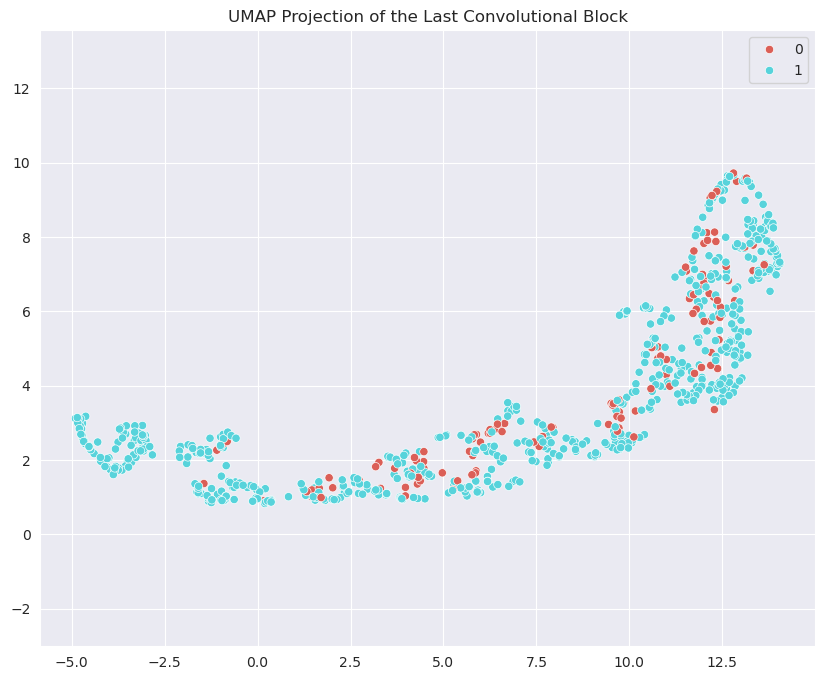

Running UMAP for 'UMAP Projection of the First Dense Layer'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


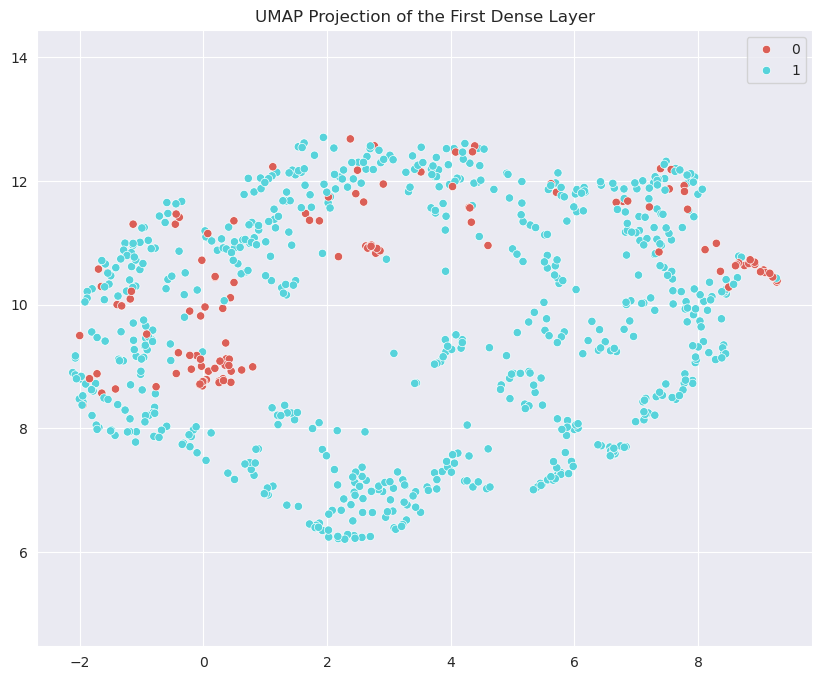

In [36]:

# The output of the entire second conv_block
conv_features, labels = extract_features(model, trainload, 'features.1')
plot_projections(conv_features, labels, 'UMAP Projection of the Last Convolutional Block')

# 'classifier.0' is the first Linear layer. Its output is the final feature representation.
dense_features, labels = extract_features(model, trainload, 'classifier.0')
plot_projections(dense_features, labels, 'UMAP Projection of the First Dense Layer')

In [37]:
def plot_tsne_projections(features, labels, title):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embedding = tsne.fit_transform(features)

    print("Plotting results...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette=sns.color_palette("hls", 2), # Use 2 colors for the 2 classes
        legend="full"
    )
    plt.title(title)
    plt.gca().set_aspect('equal', 'datalim')
    plt.show()




Plotting results...


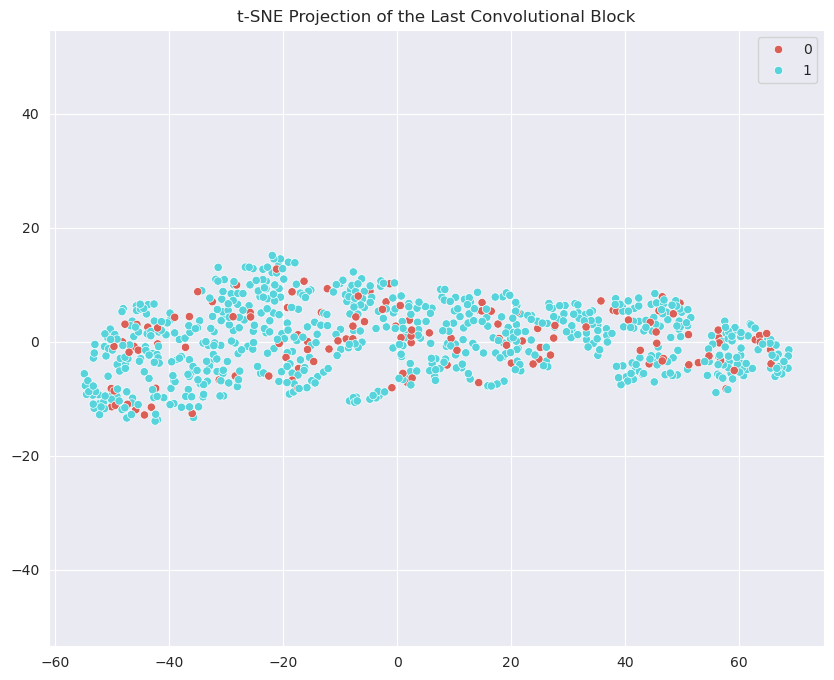

Plotting results...


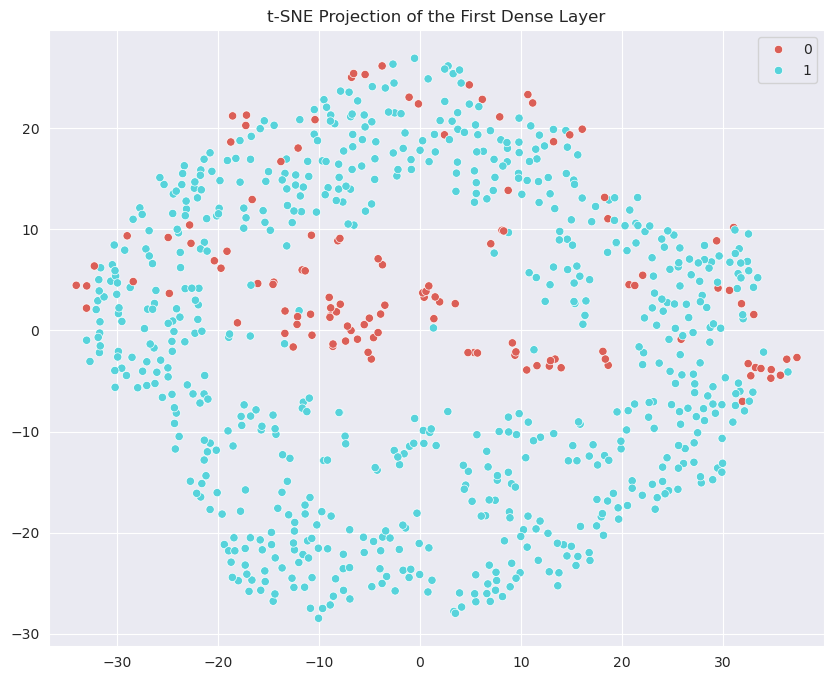

In [38]:
# last convolutional block output
plot_tsne_projections(conv_features, labels, 't-SNE Projection of the Last Convolutional Block')

# first dense layer output
plot_tsne_projections(dense_features, labels, 't-SNE Projection of the First Dense Layer')

clusters seem to overlap well, especially at the output of the last convolution layer, although they may be separated in Rn, a clear separation in 2d would be better.

# Changing Hyperparameters

due to the increase in the depth of the net, we will add a dropout aswell.

In [11]:
model_v2 = LarvaNet(input_shape, nclasses, channels=[32, 128]).to(device)
summary(model_v2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]           2,400
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]         102,400
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Linear-9                   [-1, 64]      25,690,176
          Dropout-10                   [-1, 64]               0
             ReLU-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
Total params: 25,795,426
Trainable params: 25,795,426
Non-trainable params: 0
-------------------------

In [12]:
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=1e-4) # now using weight decay
lr_scheduler_v2 = optim.lr_scheduler.StepLR(optimizer_v2, step_size=25, gamma=0.9)

In [15]:
n_epochs = 100
log = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):

    # training loop
    running_trn_loss = 0.0
    running_trn_acc = 0.0
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model_v2, data, optimizer_v2, criterion, device)
        running_trn_loss += loss
        running_trn_acc += acc
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    # calculate train loss e acc mean
    epoch_trn_loss = running_trn_loss / N
    epoch_trn_acc = running_trn_acc / N

    # validation loop
    running_val_loss = 0.0
    running_val_acc = 0.0
    N_val = len(validload)
    val_preds_list = []
    val_targets_list = []

    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model_v2, data, criterion, device)
        running_val_loss += loss
        running_val_acc += acc
        log.record((ex+(bx+1)/N_val), val_loss=loss, val_acc=acc, end='\r')

        model_v2.eval()
        ims, targets = data
        ims, targets = ims.to(device), targets.to(device)
        preds = model_v2(ims)
        pred_labels = torch.max(preds, 1)[1]
        val_preds_list.extend(pred_labels.cpu().numpy())
        val_targets_list.extend(targets.cpu().numpy())

    #  calculate validation loss e acc mean
    epoch_val_loss = running_val_loss / N_val
    epoch_val_acc = running_val_acc / N_val

    # calculate kappa cohen
    kappa = cohen_kappa_score(val_targets_list, val_preds_list)
    log.record(ex+1, val_kappa=kappa, end='\r') # Ainda gravamos no log para o gráfico

    # print after 10 epochs
    if (ex+1)%10==0:
        print(f"EPOCH: {ex+1}  ",
              f"Trn_Loss: {epoch_trn_loss:.4f}  ",
              f"Trn_Acc: {epoch_trn_acc:.4f}  ",
              f"Val_Loss: {epoch_val_loss:.4f}  ",
              f"Val_Acc: {epoch_val_acc:.4f}  ",
              f"Val_Kappa: {kappa:.4f}")

    lr_scheduler_v2.step()

EPOCH: 10.000  val_kappa: 0.128  (68.70s - 618.27s remaining)EPOCH: 10   Trn_Loss: 0.2822   Trn_Acc: 0.8921   Val_Loss: 0.3390   Val_Acc: 0.8562   Val_Kappa: 0.1280
EPOCH: 20.000  val_kappa: 0.288  (136.75s - 547.01s remaining)EPOCH: 20   Trn_Loss: 0.2505   Trn_Acc: 0.8984   Val_Loss: 0.2624   Val_Acc: 0.8719   Val_Kappa: 0.2877
EPOCH: 30.000  val_kappa: 0.539  (204.69s - 477.60s remaining)EPOCH: 30   Trn_Loss: 0.2059   Trn_Acc: 0.9111   Val_Loss: 0.2146   Val_Acc: 0.9062   Val_Kappa: 0.5393
EPOCH: 40.000  val_kappa: 0.736  (272.72s - 409.08s remaining)EPOCH: 40   Trn_Loss: 0.1657   Trn_Acc: 0.9385   Val_Loss: 0.1803   Val_Acc: 0.9344   Val_Kappa: 0.7361
EPOCH: 50.000  val_kappa: 0.727  (340.90s - 340.90s remaining)EPOCH: 50   Trn_Loss: 0.1219   Trn_Acc: 0.9546   Val_Loss: 0.2044   Val_Acc: 0.9375   Val_Kappa: 0.7274
EPOCH: 60.000  val_kappa: 0.653  (409.31s - 272.88s remaining)EPOCH: 60   Trn_Loss: 0.1032   Trn_Acc: 0.9574   Val_Loss: 0.2569   Val_Acc: 0.9250   Val_Kappa: 0.6534
EPOCH

100%|██████████| 201/201 [00:00<00:00, 6113.30it/s]


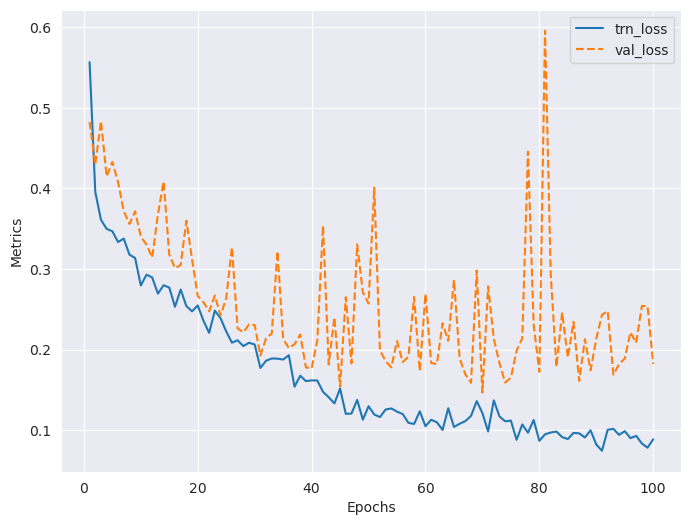

100%|██████████| 201/201 [00:00<00:00, 6074.23it/s]


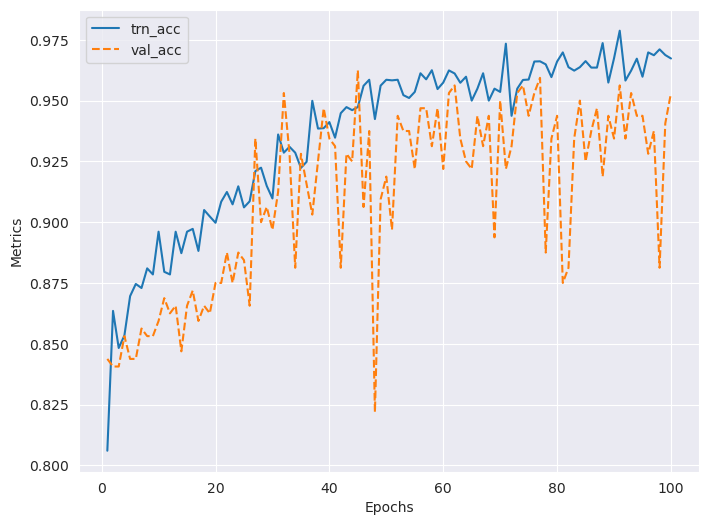

In [16]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

In [17]:
def Test(model, dataload, criterion, device):
    N = len(dataload)
    mean_loss = 0
    mean_acc  = 0

    all_predictions = []
    all_targets = []

    # Set the model to evaluation mode
    model.eval()
    # Disabling gradient
    with torch.no_grad():
        for bx, data in enumerate(dataload):
            # This part calculates the loss and accuracy per batch, which we will average
            loss, acc  = validate_batch(model, data, criterion, device)
            mean_loss += loss
            mean_acc  += acc

            ims, targets = data
            ims, targets = ims.to(device), targets.to(device)

            preds = model(ims)
            pred_labels = torch.max(preds, 1)[1]

            all_predictions.extend(pred_labels.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate the final average metrics
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    kappa = cohen_kappa_score(all_targets, all_predictions)

    # Return all three metrics
    return(mean_loss, mean_acc, kappa)


# The function now returns three values
(loss, acc, kappa) = Test(model_v2, testload, criterion, device)

print('Test Results -> Loss: {:.6f}  Acc: {:.6f}  Kappa: {:.6f}'.format(loss, acc, kappa))

Test Results -> Loss: 0.168299  Acc: 0.939583  Kappa: 0.737932


In [18]:
torch.save(model_v2.to('cpu').state_dict(), 'Larvae_v2.pth')

In [ ]:
# model_v2.load_state_dict(torch.load('Larvae_v2.pth', map_location='cuda'))
# model_v2.to('cuda')

LarvaNetV2(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (classi

In [19]:
model_v2.to(device)

LarvaNet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=401408, out_features=64, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=2, bias=True)
  )
)

Feature map shape: torch.Size([1, 128, 56, 56])
Total channels: 128
Visualizing channels 0-15 from sample 0


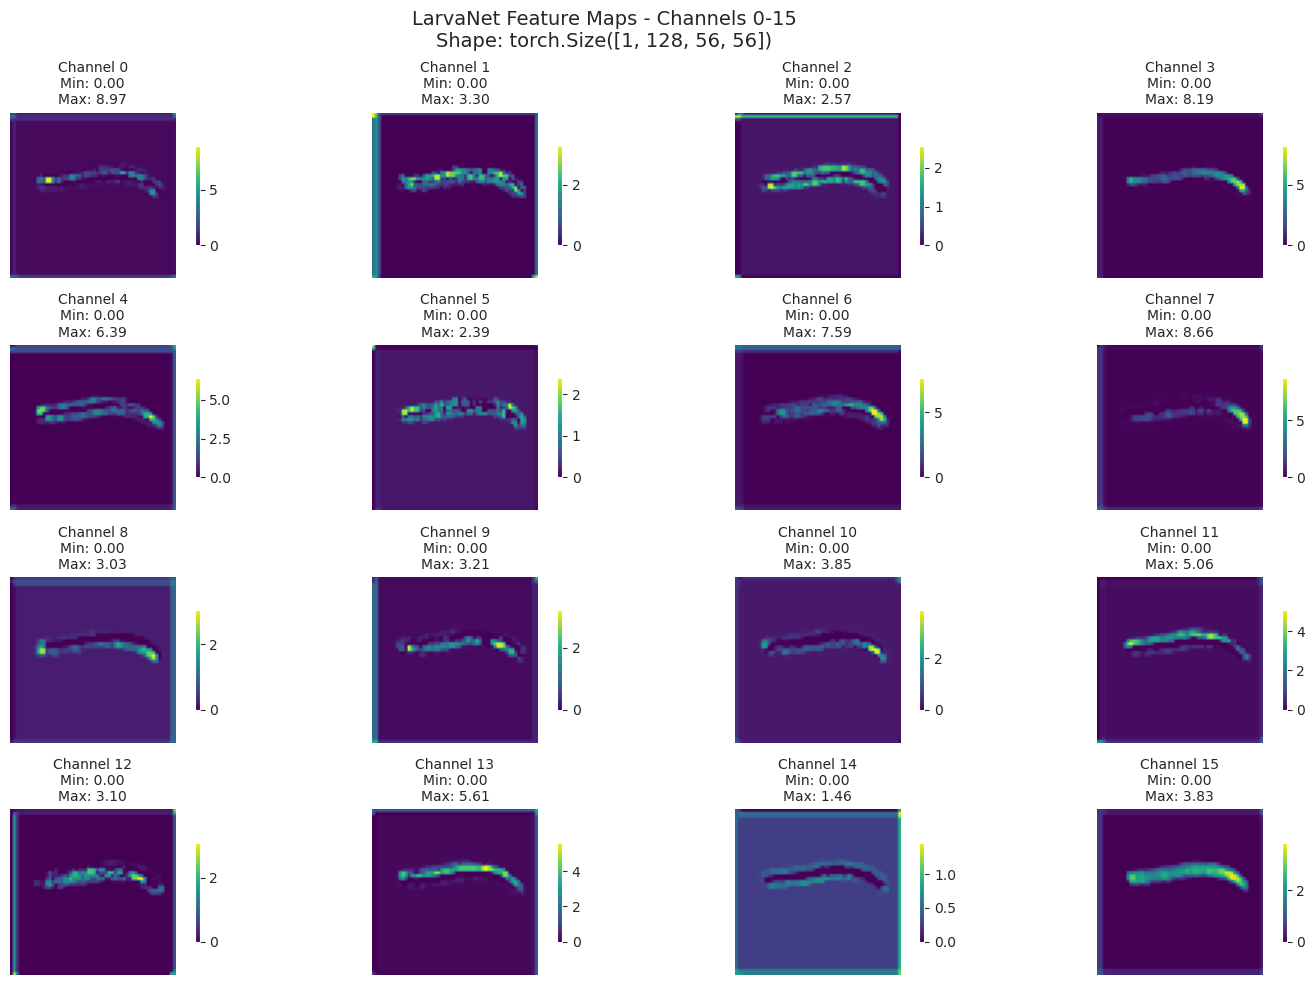

Analysis for this sample:
No dead filters found in the visualized range.


In [28]:
featmap = get_larvanet_feature_map(model_v2,target_image)
visualize_larvae_features(featmap, max_channels=16, start_channel=0)

Finding examples in the test set...
True Positive (Larva as Larva) found at index: 4
False Negative (Larva as Impurity) found at index: 11
True Negative (Impurity as Impurity) found at index: 0
False Positive (Impurity as Larva) found at index: 56


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


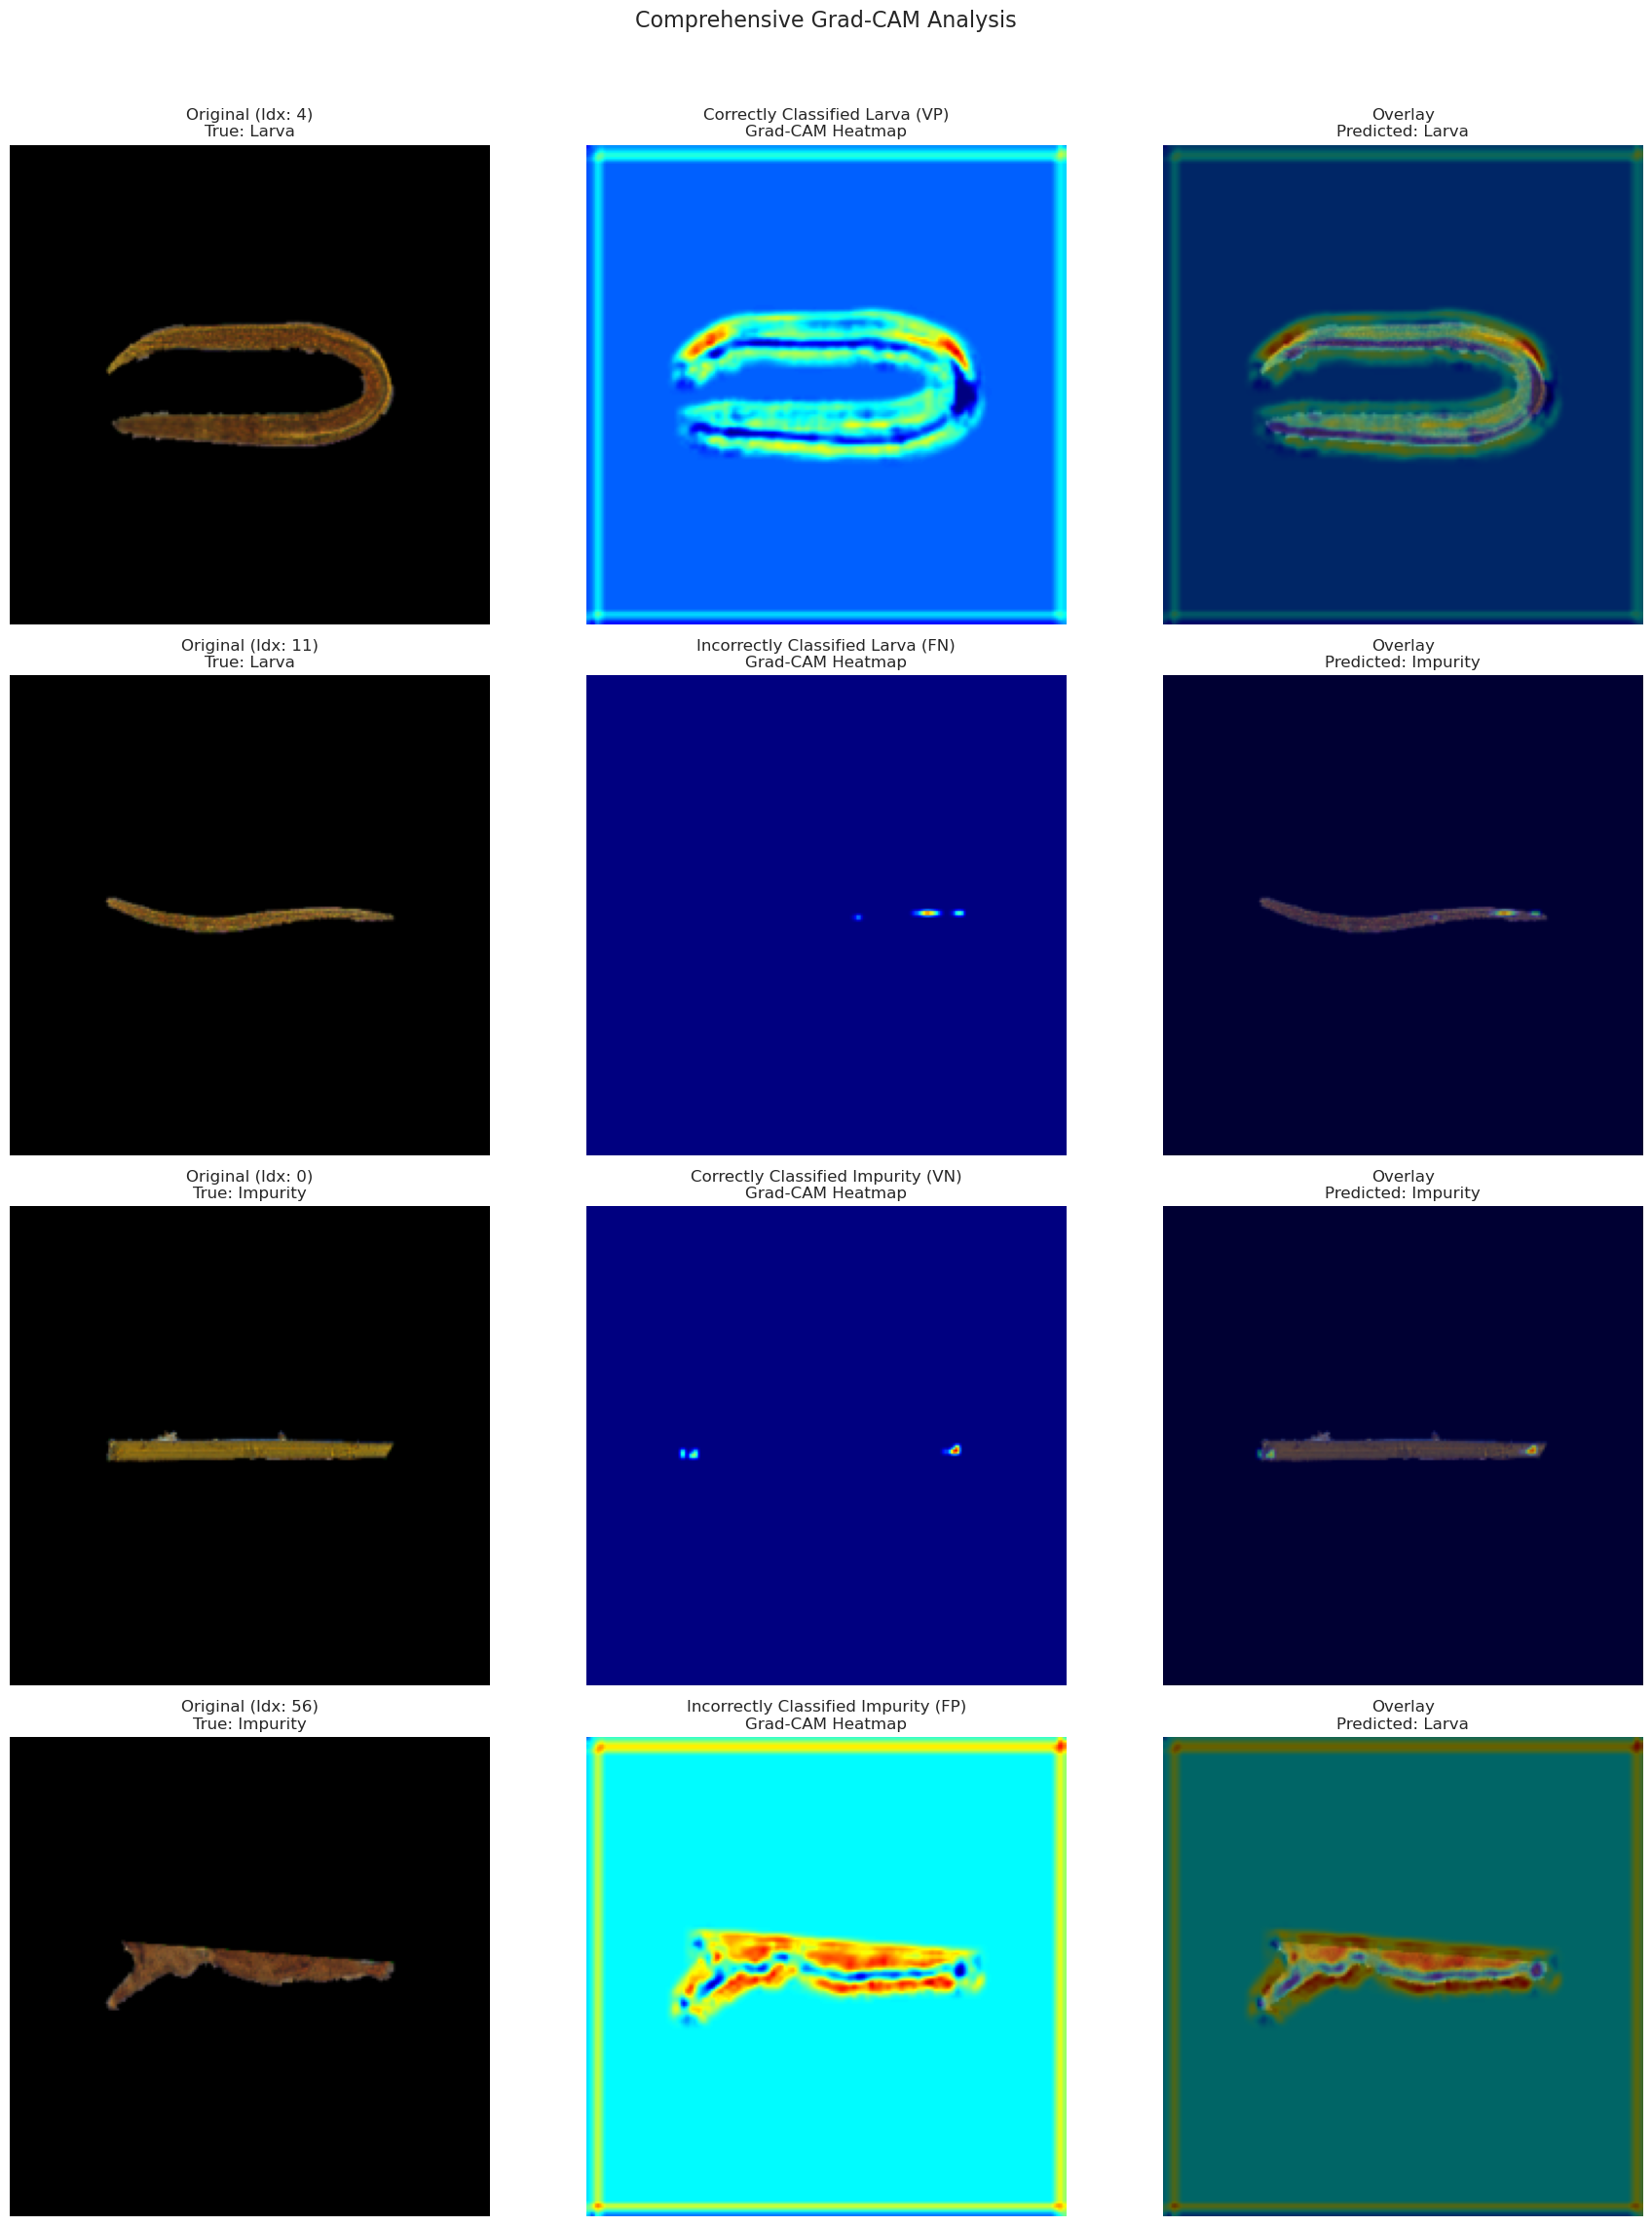

In [30]:
print("Finding examples in the test set...")
# Indices for: True Positive, False Negative, True Negative, False Positive
tp_idx, fn_idx, tn_idx, fp_idx = -1, -1, -1, -1

model_v2.eval()
with torch.no_grad():
    for i, (img_tensor, label) in enumerate(testset):
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)
        output = model_v2(img_tensor_batch)
        prediction = torch.argmax(output, dim=1).item()

        # Case: True label is Larva (0)
        if label == 0:
            if prediction == 0 and tp_idx == -1:
                tp_idx = i
            elif prediction == 1 and fn_idx == -1:
                fn_idx = i

        # Case: True label is Impurity (1)
        elif label == 1:
            if prediction == 1 and tn_idx == -1:
                tn_idx = i
            elif prediction == 0 and fp_idx == -1:
                fp_idx = i

        # Stop when all four examples are found
        if all(idx != -1 for idx in [tp_idx, fn_idx, tn_idx, fp_idx]):
            break

print(f"True Positive (Larva as Larva) found at index: {tp_idx}")
print(f"False Negative (Larva as Impurity) found at index: {fn_idx}")
print(f"True Negative (Impurity as Impurity) found at index: {tn_idx}")
print(f"False Positive (Impurity as Larva) found at index: {fp_idx}")
target_layer = model_v2.features[1][0]
grad_cam = GradCAM(model_v2, target_layer)
class_names = {0: 'Larva', 1: 'Impurity'}

# Create a 4x3 grid for the plots
fig, axes = plt.subplots(4, 3, figsize=(18, 24))
fig.suptitle('Comprehensive Grad-CAM Analysis', fontsize=16)

# Helper function to avoid code repetition
def plot_case(ax_row, case_idx, case_title):
    if case_idx == -1:
        print(f"Could not find an example for: {case_title}")
        ax_row[0].set_title(f"Example not found for\n{case_title}")
        for ax in ax_row: ax.axis('off')
        return

    img_tensor, label = testset[case_idx]
    orig_image_np = denormalize(img_tensor)

    cam, output = grad_cam(img_tensor.unsqueeze(0).to(device))
    pred_label = torch.argmax(output, dim=1).item()
    overlay, heatmap = visualize_gradcam(orig_image_np, cam)

    ax_row[0].imshow(orig_image_np)
    ax_row[0].set_title(f'Original (Idx: {case_idx})\nTrue: {class_names[label]}')
    ax_row[1].imshow(heatmap)
    ax_row[1].set_title('Grad-CAM Heatmap')
    ax_row[2].imshow(overlay)
    ax_row[2].set_title(f'Overlay\nPredicted: {class_names[pred_label]}')

# Plot all 4 cases
plot_case(axes[0], tp_idx, "True Positive")
plot_case(axes[1], fn_idx, "False Negative")
plot_case(axes[2], tn_idx, "True Negative")
plot_case(axes[3], fp_idx, "False Positive")

# Add overall titles for rows
axes[0, 1].set_title("Correctly Classified Larva (VP)\n" + axes[0, 1].get_title(), fontsize=12)
axes[1, 1].set_title("Incorrectly Classified Larva (FN)\n" + axes[1, 1].get_title(), fontsize=12)
axes[2, 1].set_title("Correctly Classified Impurity (VN)\n" + axes[2, 1].get_title(), fontsize=12)
axes[3, 1].set_title("Incorrectly Classified Impurity (FP)\n" + axes[3, 1].get_title(), fontsize=12)


for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Running UMAP for 'UMAP Projection of the Last Convolutional Block'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


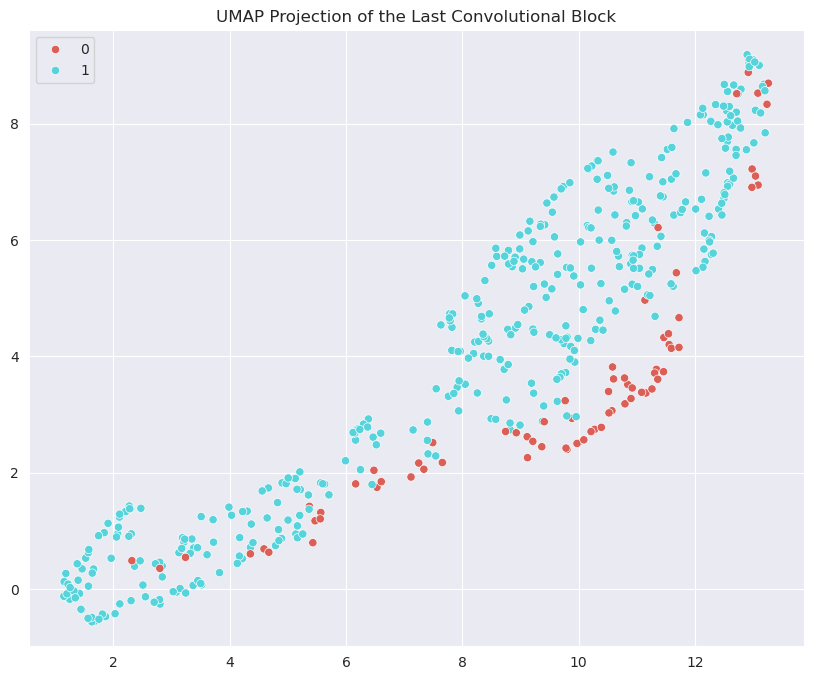

Running UMAP for 'UMAP Projection of the First Dense Layer'...


/home/kdunorat/miniconda3/envs/mo434/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Plotting results...


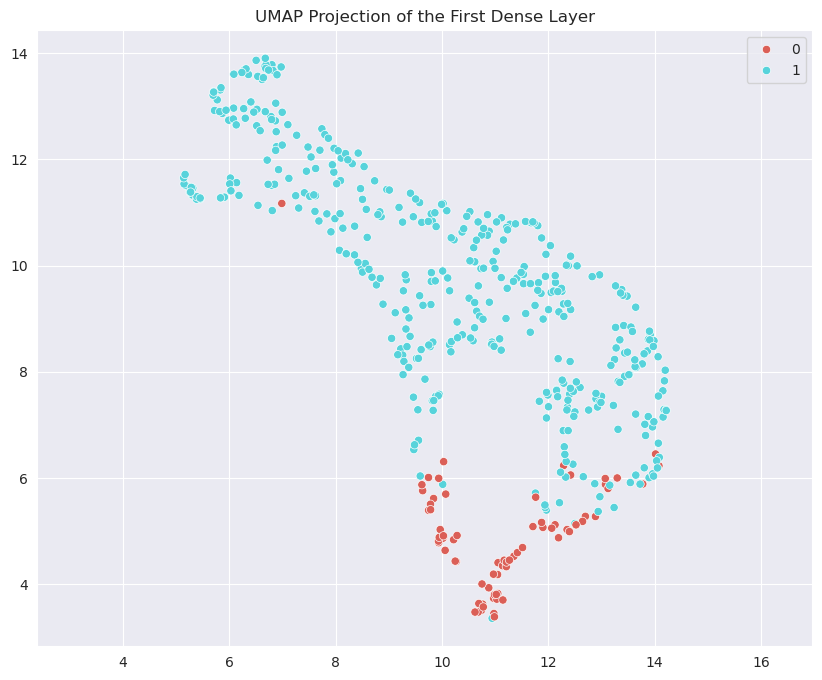

In [38]:
conv_features, labels = extract_features(model_v2, testload, 'features.1')
plot_projections(conv_features, labels, 'UMAP Projection of the Last Convolutional Block')

dense_features, labels = extract_features(model_v2, testload, 'classifier.0')
plot_projections(dense_features, labels, 'UMAP Projection of the First Dense Layer')

Plotting results...


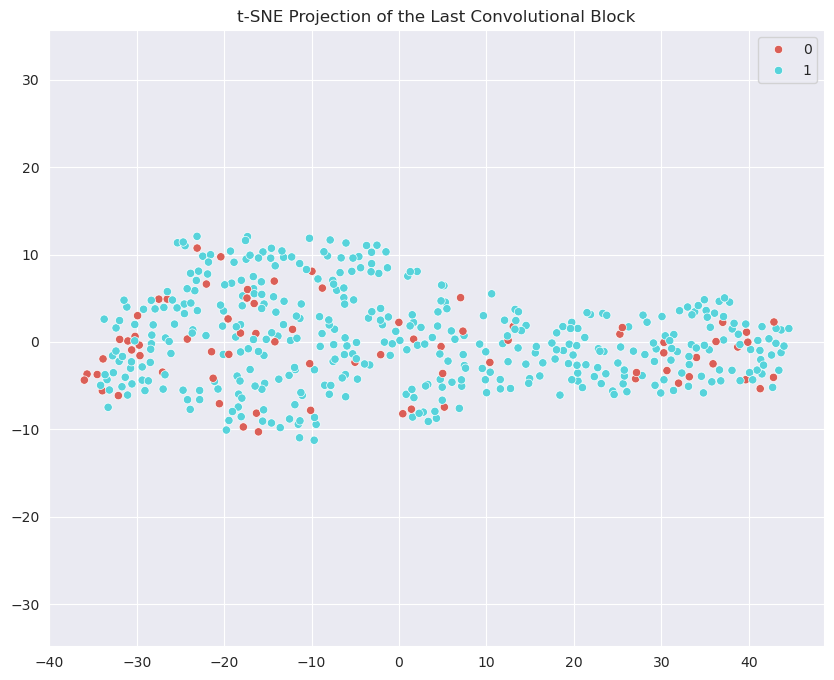

Plotting results...


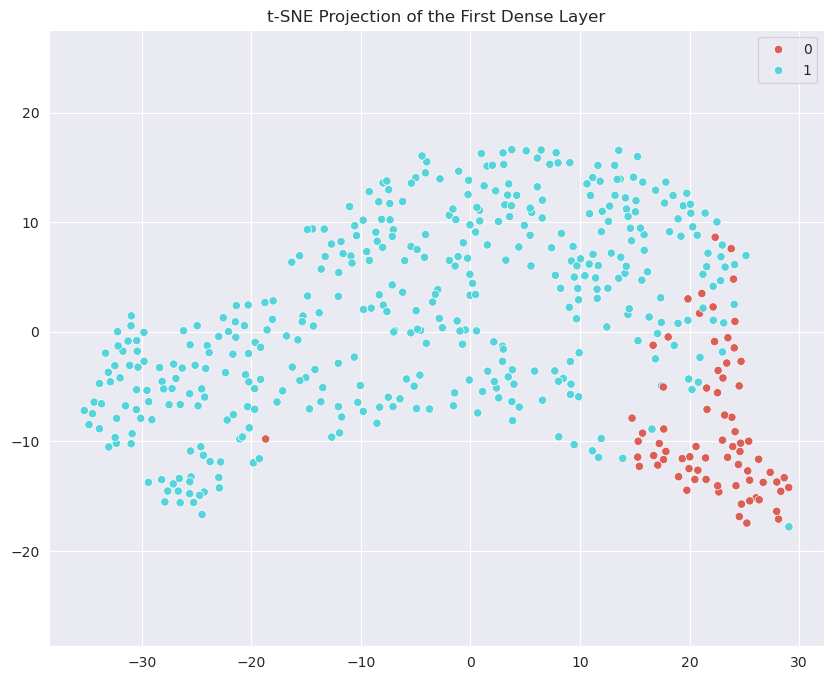

In [39]:
# last convolutional block output
plot_tsne_projections(conv_features, labels, 't-SNE Projection of the Last Convolutional Block')

# first dense layer output
plot_tsne_projections(dense_features, labels, 't-SNE Projection of the First Dense Layer')